# Project: Identify Customer Segments

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. 

These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("Rows: {}, Columns: {}".format(azdias.shape[0], azdias.shape[1]))

Rows: 891221, Columns: 85


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [9]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,GREEN_AVANTGARDE,person,ordinal,[-1]
freq,1,43,49,26


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [11]:
feat_info[feat_info.missing_or_unknown == "[XX]"]

,attribute,information_level,type,missing_or_unknown
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX]


In [12]:
azdias.CAMEO_DEU_2015[azdias.CAMEO_DEU_2015 == "XX"].count()

373

In [13]:
feat_info[feat_info.missing_or_unknown == "[-1,9]"].tail(1)

,attribute,information_level,type,missing_or_unknown
84,RELAT_AB,community,ordinal,"[-1,9]"


In [14]:
azdias.RELAT_AB[azdias.RELAT_AB == 9].count()

159

Besides integer values (0, -1, 9) there are obviously also the string values "X" and "XX" which stand for missing or unknow values. We also have to consider these values for parsing.

In [15]:
def missing_into_nan(df):
    nan_values_before = df.isnull().sum().sum()
    
    df_cleaned = df.copy()
    
    for index in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[index].missing_or_unknown
    
        missing_or_unknown = missing_or_unknown.replace("[", "")
        missing_or_unknown = missing_or_unknown.replace("]", "")
    
        missing_or_unknown = missing_or_unknown.split(',')
    
        for nan_placeholder in missing_or_unknown:
            if nan_placeholder == "X" or nan_placeholder == "XX":
                df_cleaned = df_cleaned.replace({feat_info.iloc[index].attribute: nan_placeholder}, np.nan)
            elif nan_placeholder != "":
                df_cleaned = df_cleaned.replace({feat_info.iloc[index].attribute: int(nan_placeholder)}, np.nan)
           
    nan_values_after = df_cleaned.isnull().sum().sum()
    
    print("Numpy NaN values before parsing: {}".format(nan_values_before))
    print("Numpy NaN values after parsing: {}".format(nan_values_after))
    print("{} new NaN values".format(nan_values_after - nan_values_before))

    return df_cleaned

In [16]:
azdias_nan_parsed = missing_into_nan(azdias)

Numpy NaN values before parsing: 4896838
Numpy NaN values after parsing: 8373929
3477091 new NaN values


Beside the brackets we also have to parse out the invalid character X. Missing or unknown values were converted to nan values in the process

In [17]:
print("Should be 0: {}".format(azdias_nan_parsed.RELAT_AB[azdias.RELAT_AB == 9].count() == 0))

Should be 0: True


In [18]:
print("Should be 0: {}".format(azdias_nan_parsed.CAMEO_DEU_2015[azdias.CAMEO_DEU_2015 == "XX"].count() == 0))

Should be 0: True


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [19]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

nan_per_column = azdias_nan_parsed.isnull().sum()
nan_per_column.sort_values(inplace=True)

nan_per_column

ZABEOTYP                      0
SEMIO_TRADV                   0
SEMIO_PFLICHT                 0
SEMIO_KAEM                    0
SEMIO_DOM                     0
SEMIO_KRIT                    0
SEMIO_RAT                     0
SEMIO_KULT                    0
SEMIO_ERL                     0
SEMIO_LUST                    0
SEMIO_VERT                    0
SEMIO_MAT                     0
SEMIO_REL                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
FINANZ_VORSORGER              0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
FINANZTYP                     0
ALTERSKATEGORIE_GROB       2881
GFK_URLAUBERTYP            4854
LP_STATUS_GROB             4854
LP_STATUS_FEIN             4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
                          ...  
CAMEO_IN

In [20]:
# Investigate patterns in the amount of missing data in each column.

nan_per_column.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

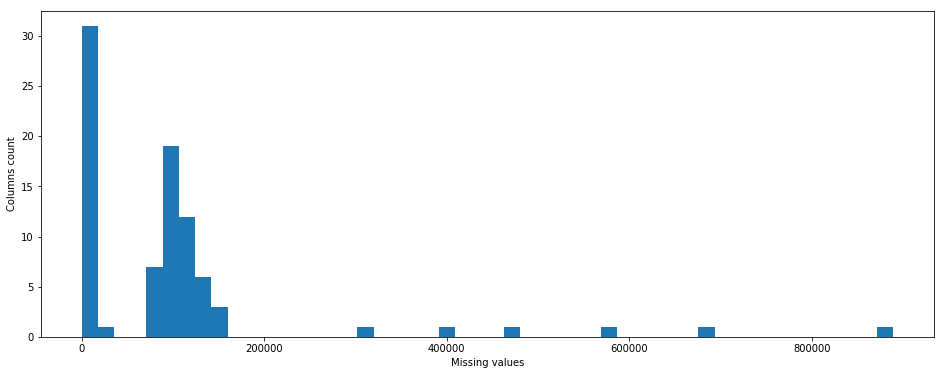

In [21]:
plt.figure(figsize=(16,6))
plt.hist(nan_per_column, bins=50)
plt.ylabel('Columns count')
plt.xlabel('Missing values')
plt.show()

In [22]:
def show_percent_per_column(nan_per_column_percent):
    nan_per_column_percent.sort_values(inplace=True)

    nan_per_column_percent.plot.bar(figsize=(16,10), facecolor='blue')

    plt.xlabel('Column name')
    plt.ylabel('Missing values in %')

    plt.show()

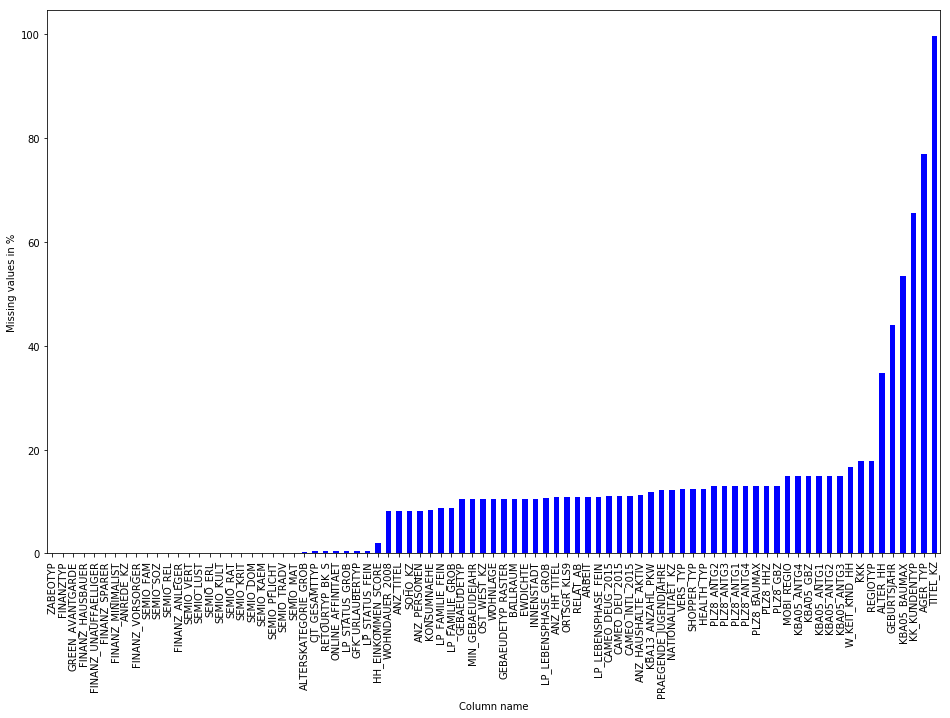

In [23]:
nan_per_column_percent = nan_per_column/(azdias_nan_parsed.shape[0]) * 100

show_percent_per_column(nan_per_column_percent)

In [24]:
null_nan_columns = nan_per_column_percent[nan_per_column_percent == 0]

print("{} columns".format(null_nan_columns.count()))
print(null_nan_columns)

24 columns
ZABEOTYP                 0.0
FINANZTYP                0.0
GREEN_AVANTGARDE         0.0
FINANZ_HAUSBAUER         0.0
FINANZ_UNAUFFAELLIGER    0.0
FINANZ_SPARER            0.0
FINANZ_MINIMALIST        0.0
ANREDE_KZ                0.0
FINANZ_VORSORGER         0.0
SEMIO_FAM                0.0
SEMIO_SOZ                0.0
SEMIO_REL                0.0
FINANZ_ANLEGER           0.0
SEMIO_VERT               0.0
SEMIO_LUST               0.0
SEMIO_ERL                0.0
SEMIO_KULT               0.0
SEMIO_RAT                0.0
SEMIO_KRIT               0.0
SEMIO_DOM                0.0
SEMIO_KAEM               0.0
SEMIO_PFLICHT            0.0
SEMIO_TRADV              0.0
SEMIO_MAT                0.0
dtype: float64


These columns have 0 NaN values and can be kept in the dataset.

In [25]:
below_20_percent_nan_columns = nan_per_column_percent[(nan_per_column_percent > 0) & (nan_per_column_percent < 20)]

print("{} columns".format(below_20_percent_nan_columns.count()))
print(below_20_percent_nan_columns)

55 columns
ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
RETOURTYP_BK_S            0.544646
ONLINE_AFFINITAET         0.544646
LP_STATUS_GROB            0.544646
GFK_URLAUBERTYP           0.544646
LP_STATUS_FEIN            0.544646
HH_EINKOMMEN_SCORE        2.058749
WOHNDAUER_2008            8.247000
ANZ_TITEL                 8.247000
SOHO_KZ                   8.247000
ANZ_PERSONEN              8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
GEBAEUDETYP              10.451729
MIN_GEBAEUDEJAHR         10.451729
OST_WEST_KZ              10.451729
WOHNLAGE                 10.451729
GEBAEUDETYP_RASTER       10.452514
BALLRAUM                 10.518154
EWDICHTE                 10.518154
INNENSTADT               10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
RELAT_AB                 10.926022
ARBEIT                   10.926022
LP_LEBENS

These columns have < 20% NaN values and can be kept also in the dataset.

In [26]:
over_20_percent_nan_columns = nan_per_column_percent[nan_per_column_percent > 20]

print("{} columns".format(over_20_percent_nan_columns.count()))
print(over_20_percent_nan_columns)

6 columns
ALTER_HH        34.813699
GEBURTSJAHR     44.020282
KBA05_BAUMAX    53.468668
KK_KUNDENTYP    65.596749
AGER_TYP        76.955435
TITEL_KZ        99.757636
dtype: float64


These 6 columns have > 20% NaN values and should be removed as outliers.

In [27]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

def drop_outliers(df):
    column_count_before = df.shape[1]
    
    df_cleaned = df.drop(over_20_percent_nan_columns.index, axis=1)
    
    column_count_after = df_cleaned.shape[1]

    print("{} Columns dropped".format(column_count_before - column_count_after))
    
    return df_cleaned

In [28]:
azdias_column_dopped = drop_outliers(azdias_nan_parsed)

6 Columns dropped


In [29]:
# Create a feat_info without the dropped columns

feat_info_column_dropped = feat_info.copy()
for column_name in over_20_percent_nan_columns.index:
    feat_info_column_dropped = feat_info_column_dropped[feat_info_column_dropped.attribute != column_name]

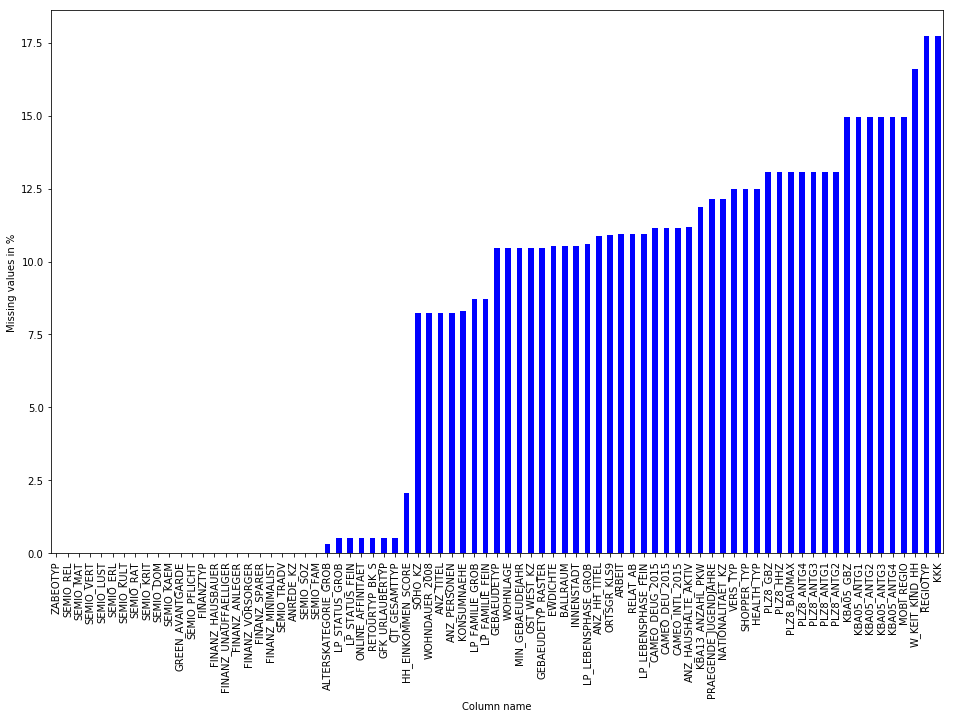

In [30]:
nan_per_column = azdias_column_dopped.isnull().sum()

show_percent_per_column(nan_per_column/(azdias_column_dopped.shape[0]) * 100)

In [31]:
nan_per_column.describe()

count        79.000000
mean      63738.025316
std       54253.866391
min           0.000000
25%           0.000000
50%       93148.000000
75%      108239.500000
max      158064.000000
dtype: float64

#### Discussion 1.1.2: Assess Missing Data in Each Column

24 columns have zero NaN values. Most of them are personality and financial typology columns. These columns are themselves classifications that have been created based on different, similar or perhaps even the same data. It seems logical that therefore no NaN values are included, but the accuracy of the classification is not known. We should keep this in mind.

55 columns have 0 > x < 20 NaN values. The percentage number of nan values is manageable.

6 columns have > 20% NaN values and I removed all off them as outlies.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [32]:
# How much data is missing in each row of the dataset?
rows_with_nan_sum = azdias_column_dopped.isnull().sum(axis=1)
rows_with_nan_sum.sort_values(inplace=True)

rows_with_percent_of_nan = rows_with_nan_sum/(azdias_column_dopped.shape[1]) * 100

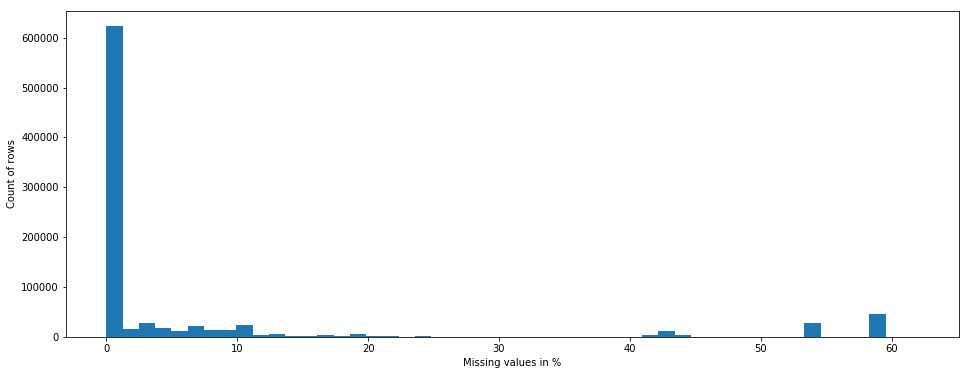

In [33]:
plt.figure(figsize=(16,6))
plt.hist(rows_with_percent_of_nan, bins=50)
plt.ylabel('Count of rows')
plt.xlabel('Missing values in %')
plt.show()

In [34]:
rows_with_nan_sum.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

More then 50% have no NaN values. 75% have <= 3 NaN values. I use this 75% percent of the rows for one subset and the rest for the other subset

In [35]:
def get_few_nan_subset(df):
    return df[df.isnull().sum(axis=1) <= 3]

def get_many_nan_subset(df):
    return df[df.isnull().sum(axis=1) > 3]

In [36]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_75_percent_lte_3 = get_few_nan_subset(azdias_column_dopped)
azdias_25_percent_gt_3 = get_many_nan_subset(azdias_column_dopped)

In [37]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

In [38]:
azdias_75_percent_lte_3.shape

(684502, 79)

In [39]:
azdias_25_percent_gt_3.shape

(206719, 79)

Both subsets contain all columns.

In [40]:
def show_countplot(column_names):
    name_count = len(column_names)
    
    fig, axs = plt.subplots(name_count, 2, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 2 , wspace = .2)
    axs = axs.ravel()
    
    i = 0
    for column_name in column_names:    
        sns.countplot(azdias_75_percent_lte_3[column_name], ax=axs[i*2])
        axs[i*2].set_title('0-3 Missing Values')
        
        sns.countplot(azdias_25_percent_gt_3[column_name], ax=axs[i*2+1])
        axs[i*2+1].set_title('>3 Missing Values')
        
        i += 1

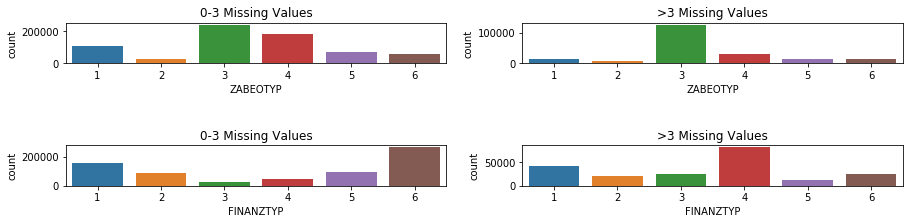

In [41]:
columns_to_compare = null_nan_columns.index[:2]

show_countplot(columns_to_compare)

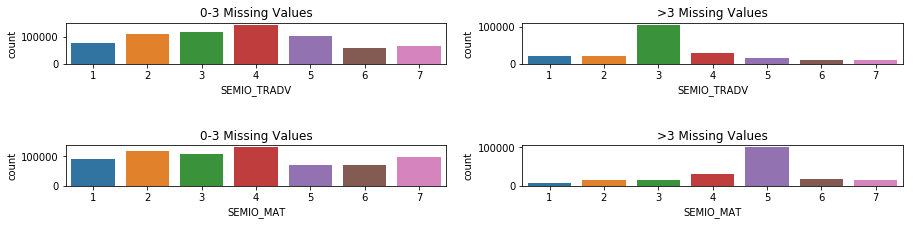

In [42]:
columns_to_compare = null_nan_columns.index[-2:]

show_countplot(columns_to_compare)

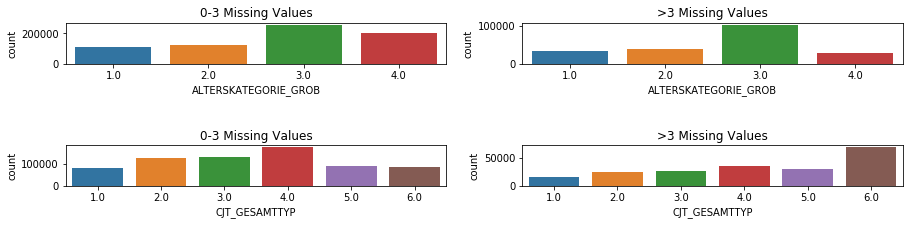

In [43]:
columns_to_compare = below_20_percent_nan_columns.index[:2]

show_countplot(columns_to_compare)

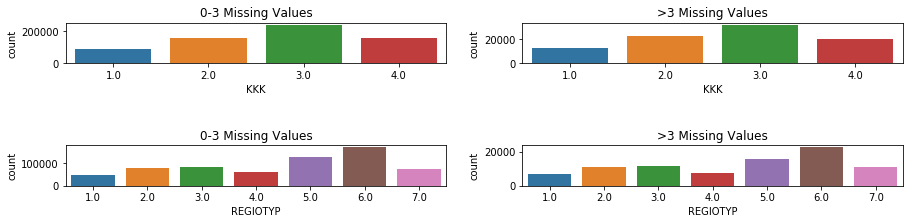

In [44]:
columns_to_compare = below_20_percent_nan_columns.index[-2:]

show_countplot(columns_to_compare)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The majority of 75% of the rows have a maximum of 3 NaN values. 50% of the rows do not have a single NaN value. 25% (206719 rows) have more than 3 NaN values, with a maximum of 49 NaN values per row.

With this information I have created two subsets. One with a maximum of 3 NaN values per row (75% of the data) and one subset with more than 3 NaN values per row (25% of the data).

Then I looked at how the NaN values are distributed between the subsets and individual columns.

For a few columns, like ALTERSKATEGORIE_GROB, KKK, REGIOTYP and ZABEOTYP, there doesn't seem to be much difference between the subsets.

For the other lines, however, there seem to be significant differences. We should keep this in mind.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [45]:
# How many features are there of each data type?

feat_info_column_dropped.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [46]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_feat_infos = feat_info_column_dropped[feat_info_column_dropped.type == "categorical"]

categorical_feat_infos

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [47]:
binary_categories = []
multi_level_categories = []

for column_name in categorical_feat_infos.attribute.values:
    categories = azdias_75_percent_lte_3[column_name].unique()
    cat_count = len(categories)
    
    if cat_count == 2:
        binary_categories.append(column_name)
        
        if categories.dtype == object:
            binary_category_to_re_encode = column_name
    elif cat_count > 2:
        multi_level_categories.append(column_name)
    else:
        print("Error - This should not happen!")

In [48]:
binary_categories

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [49]:
binary_category_to_re_encode

'OST_WEST_KZ'

In [50]:
multi_level_categories

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [51]:
azdias_75_percent_lte_3[binary_category_to_re_encode].unique()

array(['W', 'O'], dtype=object)

In [52]:
def re_encode_binary(df):
    return df.replace({binary_category_to_re_encode: {"W": 0, "O": 1}})

In [53]:
# Re-encode binary object type to integer
azdias_75_percent_lte_3_re_encode = re_encode_binary(azdias_75_percent_lte_3)

In [54]:
azdias_75_percent_lte_3_re_encode[binary_category_to_re_encode].unique()

array([0, 1])

In [55]:
# Drop multi-level features

def drop_multi_level(df):
    count_before = df.shape[1]
    
    df_cleaned = df.copy()

    for category in multi_level_categories:
        df_cleaned = df_cleaned.drop(category, axis=1)

    count_after = df_cleaned.shape[1]

    print("{} Columns dropped.".format(count_before - count_after))
    
    return df_cleaned

In [56]:
# Drop multi-level features

azdias_75_percent_lte_3_re_encode_dropped = drop_multi_level(azdias_75_percent_lte_3_re_encode)

13 Columns dropped.


#### Discussion 1.2.1: Re-Encode Categorical Features

5 columns have categorical values. In the column OST_WEST_KZ I converted "W" (west germany) to 0 and "O" (east germany) to 1. All other categorical binary columns have remained unchanged.

I have dropped the 13 multi-level category columns to keep things straightforward.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [57]:
azdias_mixed_features = azdias_75_percent_lte_3_re_encode_dropped.copy()

In [58]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_mixed_features["PRAEGENDE_JUGENDJAHRE"].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   9.,   6.,   5.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

In [59]:
def get_decade(value):
    if value in (1, 2):
        return 1
    if value in (3, 4):
        return 2
    if value in (5, 6, 7):
        return 3
    if value in (8, 9):
        return 4
    if value in (10, 11, 12, 13):
        return 5
    if value in (14, 15):
        return 6
    
    return np.nan

In [60]:
def get_movement(value):
    if value in (1, 3, 5, 8, 10, 12, 14):
        return 0
    if value in (2, 4, 6, 7, 9, 11, 13, 15):
        return 1
    
    return np.nan

In [61]:
def engineer_features_praegende_jugendjahre(df):
    df_engineered = df.copy()
    
    df_engineered['DECADE'] = df_engineered['PRAEGENDE_JUGENDJAHRE'].apply(get_decade)
    df_engineered['MOVEMENT'] = df_engineered['PRAEGENDE_JUGENDJAHRE'].apply(get_movement)
    
    return df_engineered

In [62]:
azdias_mixed_features = engineer_features_praegende_jugendjahre(azdias_mixed_features)

In [63]:
azdias_mixed_features['DECADE'].unique()

array([  6.,   4.,   2.,   5.,   3.,  nan,   1.])

In [64]:
azdias_mixed_features['MOVEMENT'].unique()

array([  0.,   1.,  nan])

In [65]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias_mixed_features["CAMEO_INTL_2015"].unique()

array(['51', '24', '43', '54', '22', '14', '13', '15', '34', '55', '12',
       '41', '25', '23', '31', '52', '35', '45', '33', '44', '32', nan], dtype=object)

In [66]:
def get_wealth(value):
    if value == np.nan:
        return value
    
    numberValue = float(value)
    if numberValue in range(11, 15+1):
        return 1
    if numberValue in range(21, 25+1):
        return 2
    if numberValue in range(31, 35+1):
        return 3
    if numberValue in range(41, 45+1):
        return 4
    if numberValue in range(51, 55+1):
        return 5
    
    return np.nan

In [67]:
def get_life_stage(value):
    if value == np.nan:
        return value
    
    numberValue = float(value)
    if numberValue % 10 == 1:
        return 1
    if numberValue % 10 == 2:
        return 2
    if numberValue % 10 == 3:
        return 3
    if numberValue % 10 == 4:
        return 4
    if numberValue % 10 == 5:
        return 5
    
    return np.nan

In [68]:
def engineer_features_cameo_intl_2015(df):
    df_engineered = df.copy()
    
    df_engineered['WEALTH'] = df_engineered['CAMEO_INTL_2015'].apply(get_wealth)
    df_engineered['LIFE_STAGE'] = df_engineered['CAMEO_INTL_2015'].apply(get_life_stage)
    
    return df_engineered

In [69]:
azdias_mixed_features = engineer_features_cameo_intl_2015(azdias_mixed_features)

In [70]:
azdias_mixed_features['WEALTH'].unique()

array([  5.,   2.,   4.,   1.,   3.,  nan])

In [71]:
azdias_mixed_features['LIFE_STAGE'].unique()

array([  1.,   4.,   3.,   2.,   5.,  nan])

In [72]:
mixed_feat_infos = feat_info_column_dropped[feat_info_column_dropped.type == "mixed"]

mixed_feat_infos

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [73]:
def drop_mixed_features(df):
    df_cleaned = df.copy()
    
    count_before = df_cleaned.shape[1]
    
    df_cleaned = df_cleaned.drop(mixed_feat_infos.attribute.values, axis=1)

    count_after = df_cleaned.shape[1]

    print("{} Columns dropped.".format(count_before - count_after))
    
    return df_cleaned


In [74]:
azdias_mixed_features_dopped = drop_mixed_features(azdias_mixed_features) 

6 Columns dropped.


#### Discussion 1.2.2: Engineer Mixed-Type Features

As formulated in the task, two new columns were created from the PRAEGENDE_JUGENDJAHRE column and two from the CAMEO_INTL_2015 column. 

One new column from the PRAEGENDE_JUGENDJAHRE data is the DECADE column with 6 different categories for the decades 1940-1990. The other new column is MOVEMENT. It has 2 different categories with 0 for mainstream and 1 for avantgarde.

The new columns generated from the CAMEO_INTL_2015 data are WEALTH and LIFE_STAGE. WEALTH has 5 catagories from 1 (wealthy) to 5 (poorer) and LIFE_STAGE has also 5 categories from 1 (Pre-Family Couples & Singles) to 5 (Elders In Retirement).

All mixed type columns were dropped.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [75]:
azdias_mixed_features_dopped.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,1.0,2.0,4.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,0.0,5.0,4.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0.0,5.0,5.0,4.0,6.0,3.0,5.0,0.0,2.0,2.0


In [76]:
azdias_mixed_features_dopped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684502 entries, 1 to 891220
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB     684502 non-null float64
ANREDE_KZ                684502 non-null int64
FINANZ_MINIMALIST        684502 non-null int64
FINANZ_SPARER            684502 non-null int64
FINANZ_VORSORGER         684502 non-null int64
FINANZ_ANLEGER           684502 non-null int64
FINANZ_UNAUFFAELLIGER    684502 non-null int64
FINANZ_HAUSBAUER         684502 non-null int64
GREEN_AVANTGARDE         684502 non-null int64
HEALTH_TYP               684502 non-null float64
RETOURTYP_BK_S           684502 non-null float64
SEMIO_SOZ                684502 non-null int64
SEMIO_FAM                684502 non-null int64
SEMIO_REL                684502 non-null int64
SEMIO_MAT                684502 non-null int64
SEMIO_VERT               684502 non-null int64
SEMIO_LUST               684502 non-null int64
SEMIO_ERL                684502 non-null int64
SEMIO_KULT               684502 non-n

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [77]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    df_cleaned = missing_into_nan(df)
    
    # remove selected columns and rows, ...
    
    df_cleaned = drop_outliers(df_cleaned)
    df_cleaned = get_few_nan_subset(df_cleaned)

    # select, re-encode, and engineer column values.

    df_cleaned = re_encode_binary(df_cleaned)
    df_cleaned = drop_multi_level(df_cleaned)
    
    df_cleaned = engineer_features_praegende_jugendjahre(df_cleaned)
    df_cleaned = engineer_features_cameo_intl_2015(df_cleaned)
    
    df_cleaned = drop_mixed_features(df_cleaned) 
    
    # Return the cleaned dataframe.
    
    return df_cleaned

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [78]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

nan_value_count = azdias_mixed_features_dopped.isnull().sum().sum()

print("Count of NaN values: {}".format(nan_value_count))
print("Count of values: {}".format(azdias_mixed_features_dopped.shape[0]))

print("{0:.3f}% of values are NaN".format(nan_value_count / azdias_mixed_features_dopped.shape[0] * 100))

Count of NaN values: 128631
Count of values: 684502
18.792% of values are NaN


In [79]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
scaler.fit(azdias_mixed_features_dopped.dropna())
    
imputer = Imputer()
azdias_imputed = imputer.fit_transform(azdias_mixed_features_dopped)
    
azdias_scaled = scaler.fit_transform(azdias_imputed)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

18.792% of the values have the type NaN. Dropping the lines would therefore lead to a considerable loss of data.

To prevent this I first temporarily removed missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [80]:
# Apply PCA to the data.

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

In [81]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

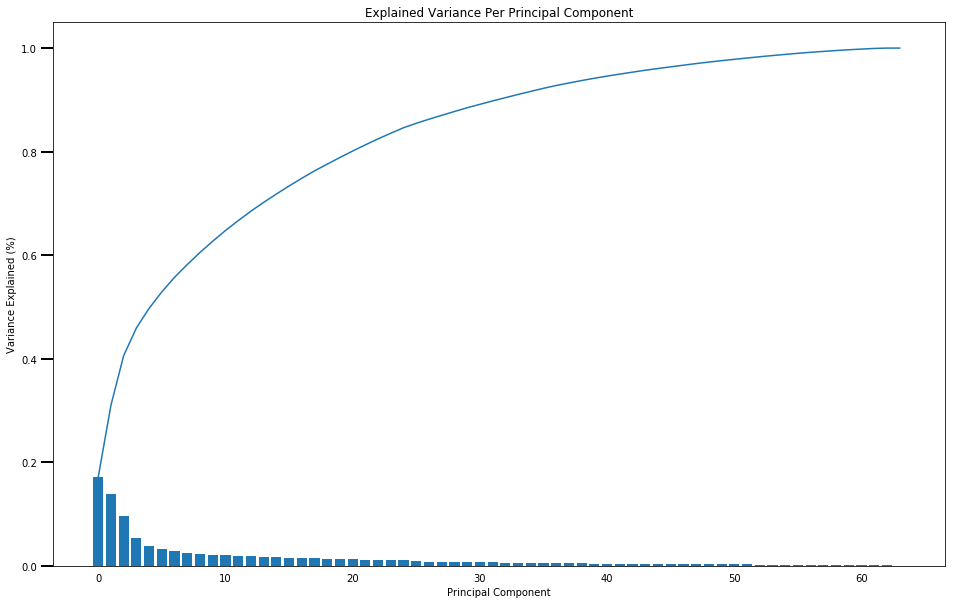

In [82]:
scree_plot(pca)

In [83]:
print("First 5 components explained variance: {}".format(pca.explained_variance_ratio_[:5].sum()))
print("First 10 components explained variance: {}".format(pca.explained_variance_ratio_[:10].sum()))
print("First 20 components explained variance: {}".format(pca.explained_variance_ratio_[:20].sum()))
print("First 30 components explained variance: {}".format(pca.explained_variance_ratio_[:30].sum()))
print("First 40 components explained variance: {}".format(pca.explained_variance_ratio_[:40].sum()))
print("First 50 components explained variance: {}".format(pca.explained_variance_ratio_[:50].sum()))

First 5 components explained variance: 0.49740260204455217
First 10 components explained variance: 0.6269400953404195
First 20 components explained variance: 0.788716811796906
First 30 components explained variance: 0.8847583600039544
First 40 components explained variance: 0.9417284740546432
First 50 components explained variance: 0.9756807657275968


In [84]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_30 = PCA(30)
azdias_pca_30 = pca_30.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

The first 5 pricipal components have already explained about 50% of variance.

I decided to keep the first 30 components, which explain about 88% of the variance and reduce the number of features by 50%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [85]:
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.columns)
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [86]:
def show_pca(full_dataset, pca, component_number):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.columns).iloc[component_number-1]
    components.sort_values(ascending=False, inplace=True)
    components = pd.concat([components.head(4), components.tail(4)])
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (10,8))
    
    title = "Component " + str(component_number)

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = "bar ", title=title);
    ax.set_ylabel("Feature Weights")

In [87]:
pca_results(azdias_mixed_features_dopped, pca_30)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
Dimension 1,0.1716,-0.1349,-0.0012,-0.2209,0.1545,-0.1240,0.0736,0.0850,0.1532,-0.1115,...,0.2139,0.0405,-0.1638,0.1400,0.1909,0.1300,0.1151,-0.1113,0.2026,-0.1241
Dimension 2,0.1388,0.2529,0.0894,0.0531,-0.2271,0.2222,-0.2010,-0.2208,0.1245,-0.0230,...,0.1007,0.0155,-0.0803,0.0738,0.0993,0.0704,-0.2411,-0.0207,0.0841,-0.0070
Dimension 3,0.0957,0.0829,-0.3686,0.1575,-0.1024,0.0993,-0.1884,-0.0933,-0.0462,0.0496,...,0.0441,0.0059,-0.0359,0.0314,0.0460,0.0301,-0.1083,0.0502,0.0244,-0.0082
Dimension 4,0.0533,-0.0410,0.0392,0.0612,-0.0008,-0.0168,-0.1277,0.0903,-0.1053,0.3967,...,0.0840,0.1412,0.0353,0.0477,0.2495,0.0933,0.0384,0.3960,-0.1246,0.0591
Dimension 5,0.0379,0.0012,0.0073,0.0856,-0.0036,-0.0604,0.0427,-0.0474,-0.0854,0.0620,...,0.0192,-0.4901,-0.4041,0.2181,0.0953,0.1484,0.0255,0.0607,-0.0099,0.0274
Dimension 6,0.0318,-0.0060,0.0216,-0.0327,0.0014,-0.0290,0.0206,-0.0366,0.0494,0.0080,...,0.0878,-0.0324,-0.0830,-0.1727,-0.0789,-0.2129,0.0062,0.0107,-0.0720,0.0560
Dimension 7,0.0282,0.0221,-0.0583,0.0529,0.0594,-0.0132,0.0752,0.0455,-0.1935,-0.0271,...,0.0501,0.1999,0.1147,-0.0097,0.1075,0.0138,0.1006,-0.0277,0.0203,-0.0758
Dimension 8,0.0246,0.1264,-0.0053,-0.0657,0.0879,-0.1329,0.1519,0.0050,0.0476,0.0414,...,0.1102,0.1221,0.0028,0.0742,-0.1007,-0.0074,0.1003,0.0410,0.0746,-0.0226
Dimension 9,0.0234,-0.0131,0.0946,0.0652,-0.1259,0.0924,-0.0377,-0.1309,0.0540,0.0005,...,0.0334,0.1659,0.0974,0.1546,0.0723,0.0719,-0.1443,0.0010,0.0160,0.0408
Dimension 10,0.0216,0.0666,0.0203,-0.0526,0.0273,0.0820,-0.0524,0.1382,-0.0226,0.0000,...,-0.0506,-0.2436,-0.1485,-0.3889,-0.0592,-0.1489,0.0216,0.0005,0.0608,-0.1591


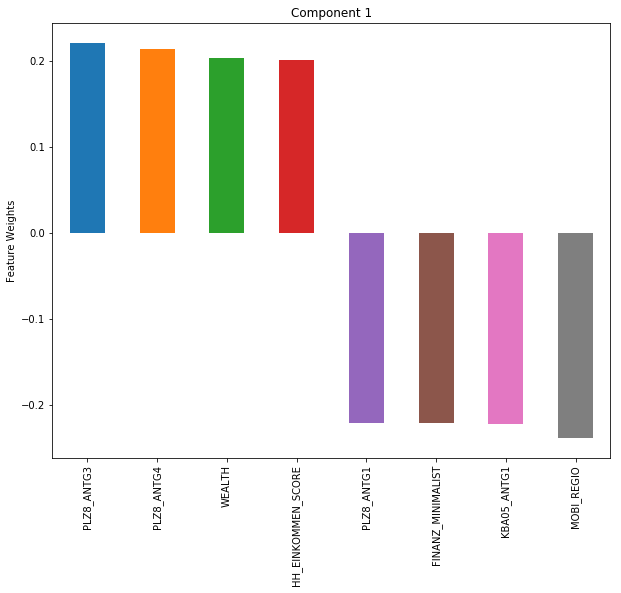

In [88]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

show_pca(azdias_mixed_features_dopped, pca_30, 1)

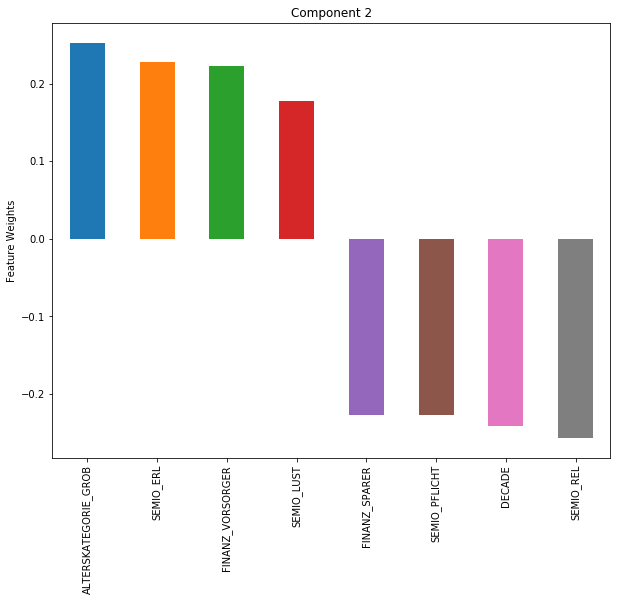

In [89]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

show_pca(azdias_mixed_features_dopped, pca_30, 2)

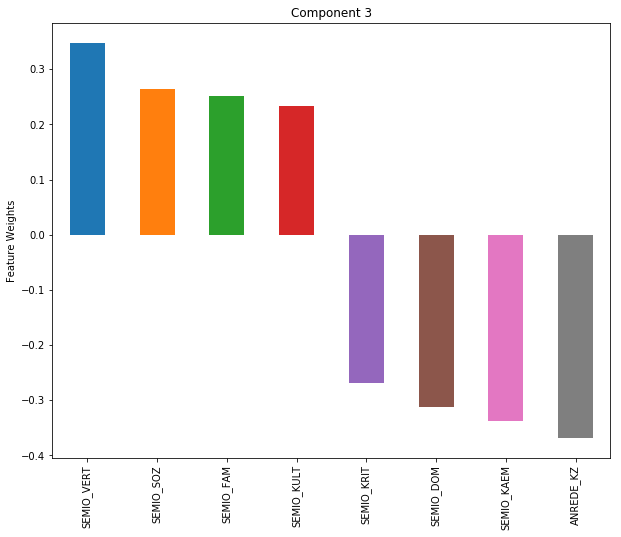

In [90]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

show_pca(azdias_mixed_features_dopped, pca_30, 3)

### Discussion 2.3: Interpret Principal Components

###### Component 1

Top positive:
 1. PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region (no to high)
 2. PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region (no to high)
 3. WEALTH: Wealthy Households to Poorer Households
 4. HH_EINKOMMEN_SCORE: Estimated household net income (hight to low)
 
Top negative:
 1. PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region (no to high)
 2. FINANZ_MINIMALIST: Financial typology (high financial interest to low)
 3. KBA05_ANTG1: Number of 1-2 family houses in the microcell (no to high)
 4. MOBI_REGIO: Movement patterns (hight to low)
 
Component 1 seems to reflect people with a low income who live in larger residential buildings, move frequently and have little financial interest.

##### Component 2

Top positive:
 1. ALTERSKATEGORIE_GROB: Estimated age based on given name analysis (low to high)
 2. SEMIO_ERL: Personality typology (high event-oriented to low)
 3. FINANZ_VORSORGER: Financial typology (be high prepared to low)
 4. SEMIO_LUST: Personality typology (hight sensual-minded to low)
 
Top negative:
 1. FINANZ_SPARER: Financial typology (hight money-saver to low)
 2. SEMIO_PFLICHT: Personality typology (high dutiful to low)
 3. DECADE: Dominating movement of person's youth (40s to 90s)
 4. SEMIO_REL: Personality typology (high relgious to low)
 
Component 2 seems to depict people with a higher age, whose formative decade was rather earlier. They are more religious, dutiful and less event-oriented and financially precautionary.

##### Component 3

Top positive:
 1. SEMIO_VERT: Personality typology (high dreamful to low)
 2. SEMIO_SOZ: Personality typology (high socially-minded to low)
 3. SEMIO_FAM: Personality typology (high family-minded to low)
 4. SEMIO_KULT: Personality typology (hight cultural-minded to low)
 
Top negative:
 1. SEMIO_KRIT: Personality typology (high critical-minded to low)
 2. SEMIO_DOM: Personality typology (high dominant-minded to low)
 3. SEMIO_KAEM: Personality typology (high combative attitude to low)
 4. ANREDE_KZ: Gender (male to female)
 
Component 3 seems to depict men who have more dreams, are socially, family and cultural minded. But they show less dominant, combative and ciritcal-minded behaviour

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [91]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [92]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

scores = []
centers = list(range(1,11))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca_30, center))

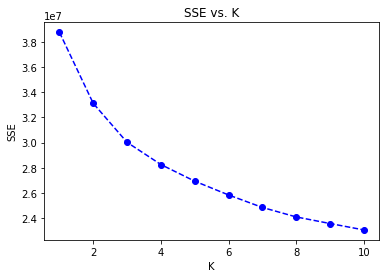

In [93]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [94]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

k_means = KMeans(n_clusters = 10)
azdias_model_10 = k_means.fit(azdias_pca_30)

In [95]:
azdias_model_10_pred = azdias_model_10.predict(azdias_pca_30)

### Discussion 3.1: Apply Clustering to General Population

There is no clear elbow in the diagram. The score decresing to the end. That is why I decided to use 10 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [96]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [97]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [98]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)

Numpy NaN values before parsing: 2252274
Numpy NaN values after parsing: 3112918
860644 new NaN values
6 Columns dropped
13 Columns dropped.
6 Columns dropped.


In [99]:
print("General Population Columns: {}".format(azdias_mixed_features_dopped.shape[1]))
print("Customer Columns: {}".format(customers_clean.shape[1]))

General Population Columns: 64
Customer Columns: 64


In [100]:
customers_imputed = imputer.transform(customers_clean)
customers_scaled = scaler.transform(customers_imputed)

In [101]:
customers_pca_transformed = pca_30.transform(customers_scaled)

In [102]:
customers_model_10_pred = azdias_model_10.predict(customers_pca_transformed)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [103]:
df_customers_pred = pd.DataFrame(customers_model_10_pred, columns=["Predictions"])
df_azidias_pred = pd.DataFrame(azdias_model_10_pred, columns=["Predictions"])

In [104]:
df_customers_pred_size = df_customers_pred.groupby('Predictions').size()
df_azidias_pred_size = df_azidias_pred.groupby('Predictions').size()

In [105]:
df_customers_pred_proportions = pd.DataFrame(df_customers_pred_size / df_customers_pred_size.sum(), columns=["Proportions"])
df_azidias_pred_proportions = pd.DataFrame(df_azidias_pred_size / df_azidias_pred_size.sum(), columns=["Proportions"])

df_customers_pred_proportions = df_customers_pred_proportions.rename_axis("Index")
df_azidias_pred_proportions = df_azidias_pred_proportions.rename_axis("Index")

print("Customer Proportions: \n{}\n".format(df_customers_pred_proportions))
print("General Proportions: {}".format(df_azidias_pred_proportions))

Customer Proportions: 
       Proportions
Index             
0         0.013447
1         0.502578
2         0.009511
3         0.122329
4         0.122418
5         0.083508
6         0.024905
7         0.091347
8         0.008921
9         0.021035

General Proportions:        Proportions
Index             
0         0.095485
1         0.169363
2         0.088017
3         0.138119
4         0.075385
5         0.111186
6         0.088870
7         0.132264
8         0.097104
9         0.004206


Text(0.5,1,'General Population Clusters')

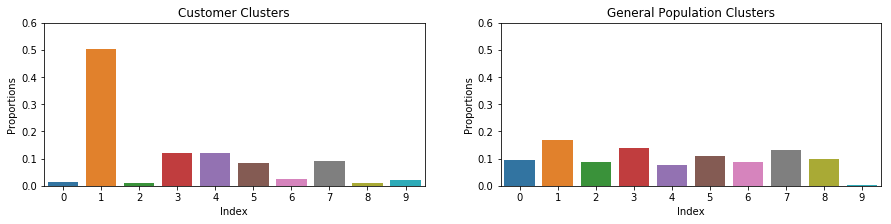

In [106]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, axs = plt.subplots(1, 2, figsize=(15, 3), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2 , wspace = .2)
axs = axs.ravel()

sns.barplot(x=df_customers_pred_proportions.index, y="Proportions", data=df_customers_pred_proportions, ax=axs[0])
sns.barplot(x=df_customers_pred_proportions.index, y="Proportions", data=df_azidias_pred_proportions, ax=axs[1])

axs[0].set(ylim=(0, 0.6))
axs[1].set(ylim=(0, 0.6))

axs[0].set_title('Customer Clusters')
axs[1].set_title('General Population Clusters')

In [107]:
diff_proportions = df_customers_pred_proportions["Proportions"] - df_azidias_pred_proportions["Proportions"]
diff_proportions.sort_values(ascending=False, inplace=True)

print("Overrepresented: \n{}\n".format(diff_proportions.head(3)))
print("Underrepresented: \n{}".format(diff_proportions.tail(3)))

Overrepresented: 
Index
1    0.333215
4    0.047033
9    0.016829
Name: Proportions, dtype: float64

Underrepresented: 
Index
2   -0.078506
0   -0.082039
8   -0.088183
Name: Proportions, dtype: float64


In [108]:
def get_cluster_values(cluster_number):
    cluster_data = scaler.inverse_transform(pca_30.inverse_transform(azdias_model_10.cluster_centers_[cluster_number]))
    
    return pd.Series(cluster_data, index=customers_clean.columns)

In [115]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

customers_overrepresented = get_cluster_values(1)

In [116]:
customers_overrepresented.head(32)

ALTERSKATEGORIE_GROB     3.355078
ANREDE_KZ                1.074274
FINANZ_MINIMALIST        4.704577
FINANZ_SPARER            1.594615
FINANZ_VORSORGER         4.291779
FINANZ_ANLEGER           1.850238
FINANZ_UNAUFFAELLIGER    1.863863
FINANZ_HAUSBAUER         2.071398
GREEN_AVANTGARDE         0.399563
HEALTH_TYP               2.242735
RETOURTYP_BK_S           3.875868
SEMIO_SOZ                4.745067
SEMIO_FAM                4.683509
SEMIO_REL                3.649199
SEMIO_MAT                3.550120
SEMIO_VERT               5.934684
SEMIO_LUST               5.059830
SEMIO_ERL                4.286432
SEMIO_KULT               4.853075
SEMIO_RAT                2.608947
SEMIO_KRIT               3.434051
SEMIO_DOM                3.273021
SEMIO_KAEM               2.595992
SEMIO_PFLICHT            3.176134
SEMIO_TRADV              2.971313
SOHO_KZ                  0.008949
VERS_TYP                 1.592960
ANZ_PERSONEN             2.079003
ANZ_TITEL               -0.000087
HH_EINKOMMEN_S

In [117]:
customers_overrepresented.tail(32)

ANZ_HAUSHALTE_AKTIV       2.093791
ANZ_HH_TITEL              0.006246
KONSUMNAEHE               3.759576
MIN_GEBAEUDEJAHR       1992.977685
OST_WEST_KZ               0.150857
KBA05_ANTG1               2.605319
KBA05_ANTG2               1.121161
KBA05_ANTG3               0.107991
KBA05_ANTG4               0.014970
KBA05_GBZ                 4.115913
BALLRAUM                  4.864383
EWDICHTE                  3.016554
INNENSTADT                5.416065
GEBAEUDETYP_RASTER        4.030517
KKK                       2.609633
MOBI_REGIO                4.138656
ONLINE_AFFINITAET         2.851182
REGIOTYP                  4.112414
KBA13_ANZAHL_PKW        678.945443
PLZ8_ANTG1                2.910482
PLZ8_ANTG2                2.336178
PLZ8_ANTG3                0.926961
PLZ8_ANTG4                0.246924
PLZ8_HHZ                  3.463275
PLZ8_GBZ                  3.880481
ARBEIT                    2.784110
ORTSGR_KLS9               4.074551
RELAT_AB                  2.561514
DECADE              

In [118]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

customers_underrepresented = get_cluster_values(8)

In [119]:
customers_underrepresented.head(32)

ALTERSKATEGORIE_GROB     1.517466
ANREDE_KZ                2.023030
FINANZ_MINIMALIST        1.201924
FINANZ_SPARER            4.215537
FINANZ_VORSORGER         2.200322
FINANZ_ANLEGER           4.104658
FINANZ_UNAUFFAELLIGER    3.601279
FINANZ_HAUSBAUER         4.161798
GREEN_AVANTGARDE         0.035214
HEALTH_TYP               2.182021
RETOURTYP_BK_S           2.428417
SEMIO_SOZ                3.197332
SEMIO_FAM                3.899853
SEMIO_REL                5.335389
SEMIO_MAT                5.144151
SEMIO_VERT               2.232883
SEMIO_LUST               2.564065
SEMIO_ERL                4.063118
SEMIO_KULT               4.206358
SEMIO_RAT                6.388342
SEMIO_KRIT               5.525340
SEMIO_DOM                6.325700
SEMIO_KAEM               6.211330
SEMIO_PFLICHT            6.348020
SEMIO_TRADV              6.004605
SOHO_KZ                  0.007944
VERS_TYP                 1.454194
ANZ_PERSONEN             1.514642
ANZ_TITEL               -0.000190
HH_EINKOMMEN_S

In [120]:
customers_underrepresented.tail(32)

ANZ_HAUSHALTE_AKTIV      14.413489
ANZ_HH_TITEL              0.054840
KONSUMNAEHE               2.105025
MIN_GEBAEUDEJAHR       1992.381039
OST_WEST_KZ               0.282142
KBA05_ANTG1               0.381135
KBA05_ANTG2               1.293345
KBA05_ANTG3               1.190662
KBA05_ANTG4               0.614706
KBA05_GBZ                 2.139856
BALLRAUM                  3.192923
EWDICHTE                  5.162452
INNENSTADT                3.374848
GEBAEUDETYP_RASTER        3.412235
KKK                       2.875753
MOBI_REGIO                1.762717
ONLINE_AFFINITAET         3.138634
REGIOTYP                  4.985860
KBA13_ANZAHL_PKW        520.954667
PLZ8_ANTG1                1.470484
PLZ8_ANTG2                3.301693
PLZ8_ANTG3                2.415396
PLZ8_ANTG4                1.283302
PLZ8_HHZ                  3.758774
PLZ8_GBZ                  2.708140
ARBEIT                    3.680243
ORTSGR_KLS9               6.965367
RELAT_AB                  3.726998
DECADE              

### Discussion 3.3: Compare Customer Data to Demographics Data

###### Cluster 1

Cluster 5 is a segment which is overrepresented in the customer data in relation to the general demographic data.

This segment seems to stand for men in higher middle age with a high income and a high online affinity. They have a high financial interest, often save and invest money and are financially inconspicuous.

They are low socially, family and sensual minded and and are very low dreamful. The length of residence is 7-10 years. The life stage is between "Families With School Age Children" and "Older Families & Mature Couples".

###### Cluster 8

Cluster 3 is a segment wich is underrepresented in the customer data in relation to the general demographic data.

This segment seems to stand for young women with a low to very low income and a high online affinity. They have low financial interest, are not money-saver or investors.

They are high socially and sensual minded. Are dreamful, not religious, materialistic or tradional minded. The life stage is "Young Couples With Children" and they living in less affluent households. The share of unemployment in the community is high.